In [1]:
import logging
from typing import Any, Dict, Optional, List

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, RegressorMixin

import dataflow.core as dtfcore
import dataflow.core.node as dtfcornode
import dataflow.core.nodes.sklearn_models as dtfcnoskmo
import dataflow.core.nodes.sources as dtfconosou
import dataflow.core.nodes.base as dtfconobas
import dataflow.core.utils as dtfcorutil
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import research_amp.soccer_prediction.preproccesing as rasoprpr
import research_amp.soccer_prediction.utils as rasoprut
import research_amp.soccer_prediction.models as rasoprmo

/app/dataflow/core/dag.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Don't recognize host: host_os_name=Linux, am_host_os_name=Linux


In [ ]:
hdbg.init_logger(verbosity=logging.DEBUG)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

### Source Node

In [3]:
# Define the necessary preprocessing step configuration.
config = {
            "load_and_preprocess_node": {
                "bucket_name": "cryptokaizen-data-test", 
                "dataset_path": "kaizen_ai/soccer_prediction/datasets/OSF_football/ISDBv2.txt"
            }
         }
node_1 = "load_and_preprocess_node"
# Initialize the FunctionDataSource with the correct configuration.
load_and_preprocess_node = dtfconosou.FunctionDataSource(
    node_1, 
    func=rasoprpr.load_and_preprocess_data, 
    func_kwargs=config[node_1]
    )
# Create train-test split using the source node.
# Define the training and testing intervals.
train_intervals = [(pd.Timestamp("2000-03-19 00:00:00"), pd.Timestamp("2000-08-26 00:03:20"))]
test_intervals = [(pd.Timestamp("2000-08-26 00:03:40"), pd.Timestamp("2000-08-27 00:04:00"))]
# Set the intervals in the source node.
load_and_preprocess_node.set_fit_intervals(train_intervals)
load_and_preprocess_node.set_predict_intervals(test_intervals)
# Generate the training dataset.
train_df_out = load_and_preprocess_node.fit()["df_out"]
# Generate the testing dataset.
test_df_out = load_and_preprocess_node.predict()["df_out"]

### Train-Test split

In [11]:
_LOG.debug(hpandas.df_to_str(train_df_out))
_LOG.debug(hpandas.df_to_str(test_df_out))

,season,league,Date,home_team,opponent,goals_scored_by_home_team,goals_scored_by_opponent,goal_difference,match_outcome,home_team_id,opponent_id,Days_Ago,Time_Weight,lambda_goals_by_home_team,lambda_goals_by_opponent,prob_win,prob_loss,prob_draw
2000-03-19 00:00:00,00-01,CHN1,2000-03-19 00:00:00,Dalian Haichang,Beijing Guoan,2,0,2,win,0,19,160,0.54003,1,1,0.445408,0.258003,0.296589
2000-03-19 00:00:20,00-01,CHN1,2000-03-19 00:00:00,Shandong Luneng,Yunnan Hongta,0,1,-1,loss,1,14,160,0.54003,1,1,0.444867,0.257827,0.297305
2000-03-19 00:00:40,00-01,CHN1,2000-03-19 00:00:00,Guangzhou Rich and Force,Chongqing Lifan,0,0,0,draw,2,17,160,0.54003,1,1,0.444115,0.258815,0.297069
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-08-26 00:02:40,00-01,ENG1,2000-08-26 00:00:00,Middlesbrough,Leeds United,1,2,-1,loss,329,269,0,1.0,1,1,0.445028,0.259352,0.295619
2000-08-26 00:03:00,00-01,ENG1,2000-08-26 00:00:00,Manchester City,Coventry City,1,2,-1,loss,333,268,0,1.0,1,1,0.445198,0.259153,0.295648
2000-08-26 00:03:20,00-01,ENG1,2000-08-26 00:00:00,Ipswich Town,Sunderland,1,0,1,win,328,272,0,1.0,1,1,0.445065,0.259115,0.29582


DEBUG None


,season,league,Date,home_team,opponent,goals_scored_by_home_team,goals_scored_by_opponent,goal_difference,match_outcome,home_team_id,opponent_id,lambda_goals_by_home_team,lambda_goals_by_opponent,prob_win,prob_loss,prob_draw
2000-08-26 00:03:40,00-01,POR1,2000-08-26 00:00:00,Guimaraes,Sporting Lisbon,1,4,-3,loss,338,325,1,1,0.445134,0.259274,0.295591
2000-08-26 00:04:00,00-01,SCO4,2000-08-26 00:00:00,Montrose,East Fife,0,1,-1,loss,182,202,1,1,0.444228,0.259849,0.295922
2000-08-26 00:04:20,00-01,SCO1,2000-08-26 00:00:00,Dunfermline Athletic,Dundee United,1,0,1,win,79,98,1,1,0.444488,0.259322,0.296189
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-08-27 00:03:20,00-01,CHE1,2000-08-27 00:00:00,FC Basel,FC St Gallen,2,2,0,draw,58,60,1,1,0.445367,0.258871,0.295761
2000-08-27 00:03:40,00-01,FRA1,2000-08-27 00:00:00,Paris Saint-Germain,SC Bastia,3,1,2,win,72,148,1,1,0.445171,0.25903,0.295798
2000-08-27 00:04:00,00-01,ARG1,2000-08-27 00:00:00,River Plate,Rosario Central,4,1,3,win,159,102,1,1,0.445395,0.258936,0.295668


DEBUG None


### Bivariate model Node

In [5]:
# Define node ID and variables.
node_3 = dtfcornode.NodeId("poisson_regressor")
# Instantiate the poisson model.
poisson_model_node = rasoprmo.BivariatePoissonModel(
    nid=node_3,
    maxiter = 1
)
df_model_fit = poisson_model_node.fit(train_df_out)["df_out"]
_LOG.debug(hpandas.df_to_str(df_model_fit))

INFO  Current params: [-0.98107097  0.17711593  0.1         0.99441743  0.99064394  0.99105803
  0.98862814  0.98968356  0.98743516  0.98709016  0.98969521  0.98603533
  0.98964001  0.99579546  0.99145889  0.98693595  0.9890213   0.98664243
  0.99154554  0.98795862  0.99092769  0.98431266  0.99050621  0.98850583
  0.99256269  0.98836083  0.98762643  0.98676008  0.98376781  0.99102921
  0.98745443  0.98755801  0.99195591  0.99070278  0.98958716  0.99488262
  0.98962827  0.99107374  0.99235558  0.99357988  0.98743721  0.99298304
  0.99347888  0.99247223  0.99279204  0.99278846  0.99392509  0.9966232
  0.99539734  0.99827375  0.99707226  0.99841926  0.99398033  0.99484975
  0.99550016  0.99881847  0.99354793  0.99500411  0.99664124  0.99632506
  0.99666145  0.9981997   0.9991487   0.99713761  0.99414094  0.99421156
  0.99788661  0.99548444  0.99501444  1.00077723  0.99753199  0.99664518
  0.99895218  0.99723465  0.99673588  0.99785485  0.99745536  0.99664534
  0.99662915  0.99921873  0.99

,prob_win,prob_loss,prob_draw
2000-03-19 00:00:00,0.445408,0.258003,0.296589
2000-03-19 00:00:20,0.444867,0.257827,0.297305
2000-03-19 00:00:40,0.444115,0.258815,0.297069
,...,...,...
2000-08-26 00:02:40,0.445028,0.259352,0.295619
2000-08-26 00:03:00,0.445198,0.259153,0.295648
2000-08-26 00:03:20,0.445065,0.259115,0.29582


DEBUG None


In [6]:
df_model_predict = poisson_model_node.predict(test_df_out)["df_out"]
_LOG.debug(hpandas.df_to_str(df_model_predict))

,prob_win,prob_loss,prob_draw
2000-08-26 00:03:40,0.445134,0.259274,0.295591
2000-08-26 00:04:00,0.444228,0.259849,0.295922
2000-08-26 00:04:20,0.444488,0.259322,0.296189
,...,...,...
2000-08-27 00:03:20,0.445367,0.258871,0.295761
2000-08-27 00:03:40,0.445171,0.25903,0.295798
2000-08-27 00:04:00,0.445395,0.258936,0.295668


DEBUG None


In [7]:
# # Combine Predictions and calculate match outcomes.
# node_4 = "match_outcomes_node"
# config = {"match_outcomes_node": {"actual_df": df_out_fit, "predictions_df": df_model_predict}}
# # Calculate match outcomes.
# match_outcomes_node = dtfconosou.FunctionDataSource(
#     node_4, 
#     func=rasoprut.calculate_match_outcome_probabilities, 
#     func_kwargs=config[node_4]
#     )
# match_outcomes_df_out = preprocessing_node.fit()["df_out"]
# _LOG.debug(hpandas.df_to_str(preprocessing_df_out))

### Intiating DAG

In [8]:
name = "soccer_prediction"
dag = dtfcore.DAG(name=name, mode = "loose")
# Note that DAG objects can print information about their state.
display(dag)

DEBUG name='soccer_prediction', mode='loose'
DEBUG save_node_io='', save_node_df_out_stats=False, profile_execution=False, dst_dir=None


<dataflow.core.dag.DAG at 0x7f63aa8d4310>:
  _nx_dag='DiGraph with 0 nodes and 0 edges' <networkx.classes.digraph.DiGraph>
  _name='soccer_prediction' <str>
  _mode='loose' <str>
  _save_node_io='' <str>
  _save_node_df_out_stats='False' <bool>
  _profile_execution='False' <bool>
  _dst_dir='None' <NoneType>
  force_free_nodes='False' <bool>
  nodes=[]
  edges=[]
  json=
  {
      "directed": true,
      "graph": {},
      "links": [],
      "multigraph": false,
      "nodes": []
  }

In [9]:
# Append dag with nodes.
dag.append_to_tail(load_and_preprocess_node)
dag.append_to_tail(poisson_model_node)
#dag.append_to_tail(combine_predictions_node)
display(dag)

<dataflow.core.dag.DAG at 0x7f63aa8d4310>:
  _nx_dag='DiGraph with 2 nodes and 1 edges' <networkx.classes.digraph.DiGraph>
  _name='soccer_prediction' <str>
  _mode='loose' <str>
  _save_node_io='' <str>
  _save_node_df_out_stats='False' <bool>
  _profile_execution='False' <bool>
  _dst_dir='None' <NoneType>
  force_free_nodes='False' <bool>
  nodes=[('load_and_preprocess_node', {'stage': <dataflow.core.nodes.sources.FunctionDataSource object at 0x7f642240b460>}), ('poisson_regressor', {'stage': <research_amp.soccer_prediction.models.BivariatePoissonModel object at 0x7f63af97b040>})]
  edges=[('load_and_preprocess_node', 'poisson_regressor', {'df_in': 'df_out'})]
  json=
  {
      "directed": true,
      "graph": {},
      "links": [
          {
              "df_in": "df_out",
              "source": "load_and_preprocess_node",
              "target": "poisson_regressor"
          }
      ],
      "multigraph": false,
      "nodes": [
          {
              "id": "load_and_preproce

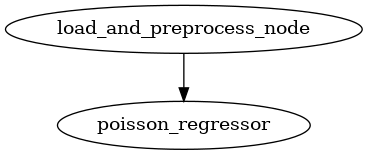

In [10]:
dtfcore.draw(dag)